<a href="https://colab.research.google.com/github/RaluIonela/Machine-Learning/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clean reinstall (safe order)
!pip install -q --force-reinstall numpy pandas scikit-learn matplotlib torch

# Verify everything loads
import sys, numpy as np, torch, sklearn, matplotlib
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("PyTorch:", torch.__version__)
print("scikit-learn:", sklearn.__version__)
print("Matplotlib:", matplotlib.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
torchaudio 2.8.0+cu126 requires torch==2.8.0, but you have torch 2.9.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.4 which is incompatible.
torchvision 0.23.0+cu126 requires torch==2.8.0, but you have torch 2.9.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.4 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.4 which is incompatible.
gcsfs 2025.3.0 requires fssp

'cpu'

In [2]:
import math, json, random, os
from dataclasses import dataclass
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, brier_score_loss,
    precision_recall_curve
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Globals
RNG = np.random.default_rng(42)
random.seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.manual_seed(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ACTIVITIES = ["reading", "maths", "art", "transition", "group_work"]


In [3]:
def moving_average(x, k=5):
    if k <= 1: return x
    pad = np.pad(x, (k//2, k//2), mode="edge")
    kernel = np.ones(k)/k
    return np.convolve(pad, kernel, mode="valid")

def generate_synthetic_day(T=600, base_noise=45.0, seed=0):
    rng = np.random.default_rng(seed)
    t = np.arange(T)

    # time-of-day features
    tod = (t % 1200) / 1200.0
    sin_t = np.sin(2*np.pi*tod)
    cos_t = np.cos(2*np.pi*tod)

    # classroom activity per step
    activity = rng.choice(ACTIVITIES, size=T, p=[0.26, 0.22, 0.16, 0.18, 0.18])

    # ambient noise shaped by activity + trend
    activity_noise = {"reading": -5.0, "maths": 0.0, "art": 1.5, "transition": 6.0, "group_work": 4.0}
    noise = base_noise + np.array([activity_noise[a] for a in activity]) + 2.5*sin_t + rng.normal(0, 1.6, size=T)
    noise = moving_average(noise, k=7)

    # background music chunked every 20 steps
    tempo = np.zeros(T); valence=np.zeros(T); arousal=np.zeros(T); centroid=np.zeros(T); lufs=np.zeros(T)
    for i in range(0, T, 20):
        tempo[i:i+20]     = rng.integers(60, 130)
        valence[i:i+20]   = rng.uniform(0.2, 0.85)
        arousal[i:i+20]   = rng.uniform(0.2, 0.9)
        centroid[i:i+20]  = rng.uniform(800, 3500)
        lufs[i:i+20]      = rng.uniform(-28, -14)

    # latent risk -> probability -> label
    activity_risk = {"reading": -0.8, "maths": -0.2, "art": 0.0, "transition": 1.1, "group_work": 0.7}
    recent_noise = moving_average(noise, k=5)

    z = (-2.0
         + 0.06*(recent_noise - 45)
         + 0.8*np.array([activity_risk[a] for a in activity])
         + 0.6*(arousal - 0.5)
         + 0.00025*(centroid - 2000)
         + 0.001*(tempo - 90)
         + 0.02*(lufs + 22)
         + 0.4*rng.normal(0, 1, size=T))
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)

    return pd.DataFrame({
        "noise_db": noise,
        "activity": activity,
        "tempo_bpm": tempo,
        "valence": valence,
        "arousal": arousal,
        "spectral_centroid": centroid,
        "loudness_lufs": lufs,
        "sin_t": sin_t, "cos_t": cos_t,
        "target_overstim": y
    })

def generate_dataset(days=30, T=600, seed=123):
    rng = np.random.default_rng(seed)
    dfs = []
    for d in range(days):
        base_noise = rng.uniform(42, 48)
        dfs.append(generate_synthetic_day(T=T, base_noise=base_noise, seed=seed+d))
    return pd.concat(dfs, ignore_index=True)

df = generate_dataset(days=10, T=600, seed=123)  # small for speed; increase days later
df.head()


,noise_db,activity,tempo_bpm,valence,arousal,spectral_centroid,loudness_lufs,sin_t,cos_t,target_overstim
0,47.028440,transition,110.0,0.34608,0.206266,1698.168401,-25.407507,0.000000,1.000000,0
1,45.750720,reading,110.0,0.34608,0.206266,1698.168401,-25.407507,0.005236,0.999986,0
2,45.774066,reading,110.0,0.34608,0.206266,1698.168401,-25.407507,0.010472,0.999945,0
3,45.055792,reading,110.0,0.34608,0.206266,1698.168401,-25.407507,0.015707,0.999877,0
4,44.487026,reading,110.0,0.34608,0.206266,1698.168401,-25.407507,0.020942,0.999781,1


In [4]:
@dataclass
class PrepArtifacts:
    ohe: OneHotEncoder
    scaler: StandardScaler
    feature_names: List[str]

def prepare_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, PrepArtifacts]:
    cat = df[["activity"]]
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    cat_arr = ohe.fit_transform(cat)
    cat_cols = [f"act_{n.split('=')[-1]}" for n in ohe.get_feature_names_out(["activity"]).tolist()]

    num_cols = ["noise_db","tempo_bpm","valence","arousal","spectral_centroid","loudness_lufs","sin_t","cos_t"]
    scaler = StandardScaler()
    num_arr = scaler.fit_transform(df[num_cols].values)

    X = np.hstack([num_arr, cat_arr])
    cols = num_cols + cat_cols
    Xdf = pd.DataFrame(X, columns=cols)
    Xdf["y"] = df["target_overstim"].astype(int).values
    return Xdf, PrepArtifacts(ohe=ohe, scaler=scaler, feature_names=cols)

def add_window_aggregates(Xdf: pd.DataFrame, window:int=10) -> pd.DataFrame:
    X = Xdf.copy()
    y = X.pop("y").values
    num_cols = [c for c in X.columns if not c.startswith("act_")]
    roll = X[num_cols].rolling(window=window, min_periods=1).mean()
    roll.columns = [f"{c}_mean{window}" for c in num_cols]
    Xagg = pd.concat([X, roll], axis=1).iloc[window-1:].reset_index(drop=True)
    y = y[window-1:]
    Xagg["y"] = y
    return Xagg

Xdf, prep = prepare_features(df)

# contiguous time split
n = len(Xdf)
train_end = int(0.6*n); val_end = int(0.8*n)
X_train = Xdf.iloc[:train_end].reset_index(drop=True)
X_val   = Xdf.iloc[train_end:val_end].reset_index(drop=True)
X_test  = Xdf.iloc[val_end:].reset_index(drop=True)

Xagg_train = add_window_aggregates(X_train, window=10)
Xagg_val   = add_window_aggregates(pd.concat([X_train.tail(9), X_val], ignore_index=True), window=10)
Xagg_test  = add_window_aggregates(pd.concat([X_val.tail(9), X_test], ignore_index=True), window=10)

X_tr = Xagg_train.drop(columns=["y"]).values; y_tr = Xagg_train["y"].values
X_va = Xagg_val.drop(columns=["y"]).values;   y_va = Xagg_val["y"].values
X_te = Xagg_test.drop(columns=["y"]).values;  y_te = Xagg_test["y"].values
X_tr.shape, X_va.shape, X_te.shape


((3591, 21), (1200, 21), (1200, 21))

In [5]:
def eval_probs(y_true, y_prob) -> Dict[str,float]:
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        "ROC_AUC": float(roc_auc_score(y_true, y_prob)),
        "PR_AUC": float(average_precision_score(y_true, y_prob)),
        "F1": float(f1_score(y_true, y_pred)),
        "Brier": float(brier_score_loss(y_true, y_prob)),
    }

# Logistic Regression
lr = LogisticRegression(max_iter=200, class_weight="balanced")
lr.fit(X_tr, y_tr)
lr_prob = lr.predict_proba(X_te)[:,1]
lr_metrics = eval_probs(y_te, lr_prob)
print("LogReg:", lr_metrics)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced")
rf.fit(X_tr, y_tr)
rf_prob = rf.predict_proba(X_te)[:,1]
rf_metrics = eval_probs(y_te, rf_prob)
print("RandomForest:", rf_metrics)


LogReg: {'ROC_AUC': 0.6653819865505457, 'PR_AUC': 0.3158149007155702, 'F1': 0.3913978494623656, 'Brier': 0.26775575811655716}
RandomForest: {'ROC_AUC': 0.6017374049167677, 'PR_AUC': 0.24439435791346525, 'F1': 0.0, 'Brier': 0.155990875}


In [6]:
# build sequences from already scaled feature frames (X_train/X_val/X_test)
def make_seq_from_scaled(Xpart: pd.DataFrame, w: int):
    X = Xpart.drop(columns=["y"]).values.astype(np.float32)
    y = Xpart["y"].values.astype(np.int64)
    seqX, seqY = [], []
    for i in range(len(X)-w):
        seqX.append(X[i:i+w]); seqY.append(y[i+w])
    return np.asarray(seqX), np.asarray(seqY)

WINDOW = 20
seqX_tr, seqY_tr = make_seq_from_scaled(X_train, WINDOW)
seqX_va, seqY_va = make_seq_from_scaled(X_val,   WINDOW)
seqX_te, seqY_te = make_seq_from_scaled(X_test,  WINDOW)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(SeqDataset(seqX_tr, seqY_tr), batch_size=64, shuffle=True)
val_loader   = DataLoader(SeqDataset(seqX_va, seqY_va), batch_size=64)
test_loader  = DataLoader(SeqDataset(seqX_te, seqY_te), batch_size=64)

class LSTMHead(nn.Module):
    def __init__(self, d_in, hidden=64, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(d_in, hidden, num_layers=1, batch_first=True)
        self.do = nn.Dropout(dropout)
        self.out = nn.Linear(hidden, 1)
    def forward(self, x):
        o,_ = self.lstm(x)
        last = self.do(o[:, -1, :])
        return self.out(last).squeeze(-1)

d_in = len(prep.feature_names)
model = LSTMHead(d_in=d_in, hidden=64, dropout=0.1).to(DEVICE)


In [7]:
pos_weight = max(1.0, (len(seqY_tr)-seqY_tr.sum())/max(1,seqY_tr.sum()))
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=DEVICE))
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

best_pr, best_state = -1.0, None
EPOCHS = 8

for ep in range(1, EPOCHS+1):
    # train
    model.train(); losses=[]
    for xb, yb in train_loader:
        xb = xb.to(DEVICE); yb = yb.float().to(DEVICE)
        opt.zero_grad()
        logit = model(xb)
        loss = criterion(logit, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        losses.append(loss.item())
    # validate
    model.eval(); preds=[]; trues=[]
    with torch.no_grad():
        for xb, yb in val_loader:
            prob = torch.sigmoid(model(xb.to(DEVICE))).cpu().numpy()
            preds.append(prob); trues.append(yb.numpy())
    preds = np.concatenate(preds); trues = np.concatenate(trues)
    pr = average_precision_score(trues, preds)
    roc = roc_auc_score(trues, preds)
    print(f"Epoch {ep}: loss={np.mean(losses):.4f}  valPR={pr:.3f}  valROC={roc:.3f}")
    if pr > best_pr:
        best_pr, best_state = pr, model.state_dict()

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 1: loss=1.1438  valPR=0.256  valROC=0.581
Epoch 2: loss=1.1333  valPR=0.267  valROC=0.597
Epoch 3: loss=1.1255  valPR=0.274  valROC=0.607
Epoch 4: loss=1.1216  valPR=0.276  valROC=0.608
Epoch 5: loss=1.1201  valPR=0.278  valROC=0.610
Epoch 6: loss=1.1147  valPR=0.282  valROC=0.613
Epoch 7: loss=1.1111  valPR=0.281  valROC=0.615
Epoch 8: loss=1.1047  valPR=0.283  valROC=0.611


LSTM: {'ROC_AUC': 0.6055445024042493, 'PR_AUC': 0.271775189704219, 'F1': 0.3443708609271523, 'Brier': 0.2730696647481687, 'ECE': 0.342886169886185}


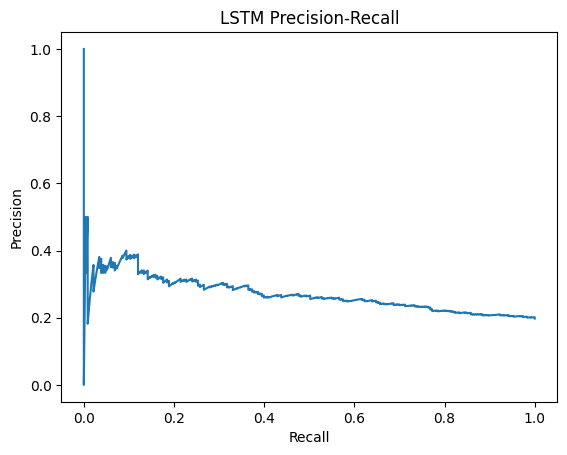

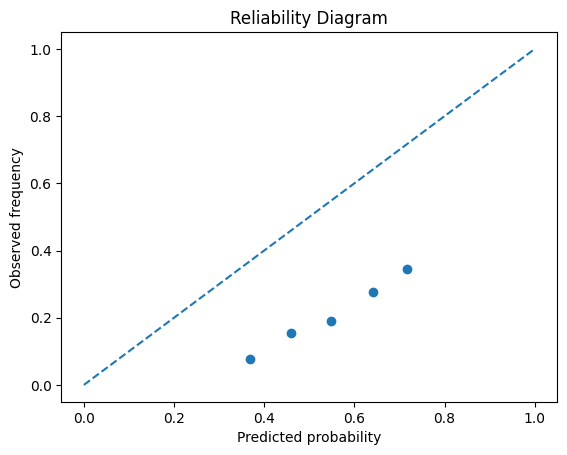

In [8]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0., 1., n_bins+1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0; total = len(y_true)
    for b in range(n_bins):
        idx = inds == b
        if not np.any(idx): continue
        conf = np.mean(y_prob[idx]); acc = np.mean(y_true[idx])
        ece += (np.sum(idx)/total) * abs(acc - conf)
    return float(ece)

# probs on test
model.eval(); lstm_prob=[]; y_true=[]
with torch.no_grad():
    for xb, yb in test_loader:
        prob = torch.sigmoid(model(xb.to(DEVICE))).cpu().numpy()
        lstm_prob.append(prob); y_true.append(yb.numpy())
lstm_prob = np.concatenate(lstm_prob); y_true = np.concatenate(y_true)

lstm_metrics = eval_probs(y_true, lstm_prob)
lstm_metrics["ECE"] = expected_calibration_error(y_true, lstm_prob)
print("LSTM:", lstm_metrics)

# PR curve
pr, rc, th = precision_recall_curve(y_true, lstm_prob)
plt.figure()
plt.plot(rc, pr)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("LSTM Precision-Recall")
plt.show()

# reliability diagram
bins = np.linspace(0,1,11)
inds = np.digitize(lstm_prob, bins)-1
xs, ys = [], []
for b in range(10):
    idx = inds==b
    if np.any(idx):
        xs.append(np.mean(lstm_prob[idx]))
        ys.append(np.mean(y_true[idx]))
plt.figure()
plt.plot([0,1],[0,1],'--')
plt.scatter(xs, ys)
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability Diagram")
plt.show()


In [9]:
def ablation_keep_cols(keep_cols: List[str], window=WINDOW, hidden=64, epochs=4):
    # slice features
    idx = [prep.feature_names.index(c) for c in keep_cols]
    def slice_and_seq(Xpart):
        X = Xpart.drop(columns=["y"]).values[:, idx].astype(np.float32)
        y = Xpart["y"].values.astype(np.int64)
        seqX, seqY = [], []
        for i in range(len(X)-window):
            seqX.append(X[i:i+window]); seqY.append(y[i+window])
        return np.asarray(seqX), np.asarray(seqY)

    sx_tr, sy_tr = slice_and_seq(X_train)
    sx_va, sy_va = slice_and_seq(X_val)
    sx_te, sy_te = slice_and_seq(X_test)

    tl = DataLoader(SeqDataset(sx_tr, sy_tr), batch_size=64, shuffle=True)
    vl = DataLoader(SeqDataset(sx_va, sy_va), batch_size=64)
    te = DataLoader(SeqDataset(sx_te, sy_te), batch_size=64)

    m = LSTMHead(d_in=len(keep_cols), hidden=hidden).to(DEVICE)
    posw = max(1.0, (len(sy_tr)-sy_tr.sum())/max(1,sy_tr.sum()))
    crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([posw], device=DEVICE))
    opt = torch.optim.AdamW(m.parameters(), lr=1e-3)
    best, best_state = -1.0, None
    for ep in range(1, epochs+1):
        m.train()
        for xb, yb in tl:
            xb = xb.to(DEVICE); yb = yb.float().to(DEVICE)
            opt.zero_grad(); loss = crit(m(xb), yb); loss.backward(); opt.step()
        # val
        m.eval(); preds=[]; trues=[]
        with torch.no_grad():
            for xb, yb in vl:
                preds.append(torch.sigmoid(m(xb.to(DEVICE))).cpu().numpy()); trues.append(yb.numpy())
        pr = average_precision_score(np.concatenate(trues), np.concatenate(preds))
        if pr > best: best, best_state = pr, m.state_dict()
    if best_state is not None: m.load_state_dict(best_state)

    # test
    m.eval(); preds=[]; trues=[]
    with torch.no_grad():
        for xb, yb in te:
            preds.append(torch.sigmoid(m(xb.to(DEVICE))).cpu().numpy()); trues.append(yb.numpy())
    yprob = np.concatenate(preds); ytrue = np.concatenate(trues)
    return eval_probs(ytrue, yprob)

groups = {
    "keep_all": prep.feature_names,
    "no_music": [c for c in prep.feature_names if c not in ["tempo_bpm","valence","arousal","spectral_centroid","loudness_lufs"]],
    "no_noise": [c for c in prep.feature_names if c != "noise_db"],
    "no_context": [c for c in prep.feature_names if not c.startswith("act_") and c not in ["sin_t","cos_t"]],
}
ablation_results = {k: ablation_keep_cols(v) for k,v in groups.items()}
ablation_results


{'keep_all': {'ROC_AUC': 0.6043027223987202,
  'PR_AUC': 0.2610280520281277,
  'F1': 0.35507246376811596,
  'Brier': 0.274318823679974},
 'no_music': {'ROC_AUC': 0.5956125283819244,
  'PR_AUC': 0.2542974350296302,
  'F1': 0.3380281690140845,
  'Brier': 0.28649106904856075},
 'no_noise': {'ROC_AUC': 0.5635233921441553,
  'PR_AUC': 0.23433161770263203,
  'F1': 0.32503276539973786,
  'Brier': 0.24556837431675382},
 'no_context': {'ROC_AUC': 0.5968565744093614,
  'PR_AUC': 0.2537947937921592,
  'F1': 0.34811715481171546,
  'Brier': 0.29099271986889286}}

In [10]:
def recommend_tracks(model, prep, context_row: pd.Series, catalogue: pd.DataFrame,
                     goal: str = "calm", lam: float = 0.3, window: int = WINDOW):
    # mismatch target per goal
    if goal == "calm":
        target = {"arousal":0.30, "tempo_bpm":75,  "spectral_centroid":1200, "loudness_lufs":-24, "valence":0.50}
    elif goal == "focus":
        target = {"arousal":0.45, "tempo_bpm":90,  "spectral_centroid":1800, "loudness_lufs":-22, "valence":0.55}
    else:  # energize
        target = {"arousal":0.65, "tempo_bpm":105, "spectral_centroid":2400, "loudness_lufs":-20, "valence":0.60}

    def mismatch(track):
        diffs = [(float(track[k]) - v)**2 for k,v in target.items()]
        return math.sqrt(sum(diffs)/len(diffs))

    # build a synthetic window by repeating recent context; replace last step with candidate track
    numeric = ["noise_db","tempo_bpm","valence","arousal","spectral_centroid","loudness_lufs","sin_t","cos_t"]
    cat = ["activity"]
    seq_rows = [context_row.copy() for _ in range(window-1)]
    outs = []
    for _, tr in catalogue.iterrows():
        row = context_row.copy()
        for k in ["tempo_bpm","valence","arousal","spectral_centroid","loudness_lufs"]:
            row[k] = tr[k]
        block = pd.DataFrame(seq_rows + [row])
        num_arr = prep.scaler.transform(block[numeric].values)
        cat_arr = prep.ohe.transform(block[cat].values)
        X = np.hstack([num_arr, cat_arr]).astype(np.float32)
        with torch.no_grad():
            prob = torch.sigmoid(model(torch.from_numpy(X[None,...]).to(DEVICE))).item()
        score = prob + lam * mismatch(tr)
        outs.append((tr["track_id"], prob, score))
    return sorted(outs, key=lambda x: x[2])

# tiny catalogue
catalogue = pd.DataFrame([
    {"track_id":"calm_piano","tempo_bpm":72,"valence":0.45,"arousal":0.30,"spectral_centroid":1100,"loudness_lufs":-25},
    {"track_id":"soft_strings","tempo_bpm":78,"valence":0.50,"arousal":0.35,"spectral_centroid":1300,"loudness_lufs":-24},
    {"track_id":"lofi_focus","tempo_bpm":88,"valence":0.55,"arousal":0.45,"spectral_centroid":1700,"loudness_lufs":-22},
    {"track_id":"bright_uplift","tempo_bpm":108,"valence":0.65,"arousal":0.70,"spectral_centroid":2600,"loudness_lufs":-20},
])

# pick the latest context
context_row = df.iloc[-1].copy()
recs = recommend_tracks(model, prep, context_row, catalogue, goal="calm", lam=0.3, window=WINDOW)
recs


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


[('calm_piano', 0.519364595413208, 13.942480664344446),
 ('soft_strings', 0.5243608355522156, 13.946806402586562),
 ('lofi_focus', 0.5351664423942566, 67.64041549192837),
 ('bright_uplift', 0.5584700703620911, 188.44112835738974)]